In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random


from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

##### Домашнее задание

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [2]:
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1)

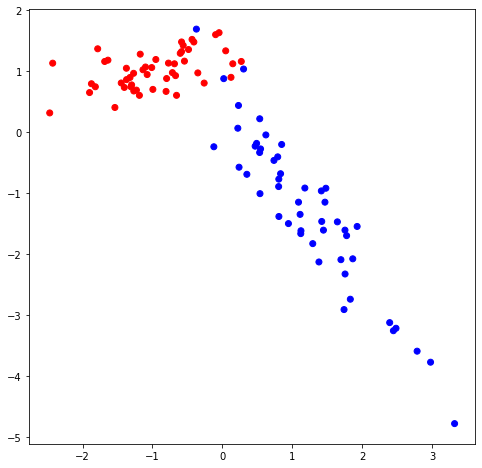

In [3]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [4]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] 
    bootstrap = [] 
    out_of_bag = [] # данные которые не вошли в выборку
    
    for i in range(N): 
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        index = [i for i in range(0,data.shape[0])] # список всех индексов 
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1) 
            if sample_index in index:      
                index.remove(sample_index)  # исключаем индексы данных, которые попадают в обучающую выборку
            b_data[j] = data[sample_index] 
            b_labels[j] = labels[sample_index]
        
        oob_data = data[index].copy()     
        oob_labels = labels[index].copy()
        out_of_bag.append((oob_data, oob_labels)) # получаем данные, которые не участвуют в обучении
        
        
        bootstrap.append((b_data, b_labels))
#         print(f'Train: {b_data.shape}. Test: {oob_data.shape}\n')
        
    return bootstrap, out_of_bag

In [5]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes) # перемешаем индексы
    subsample = sample_indexes[0:len_subsample].copy() # возьмем первые len_subsample
#     for _ in range(len_subsample):
#         subsample.append(sample_indexes.pop())
        
    #print(f'subsample = {subsample}')
    return subsample

In [6]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

#### 4*. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

In [8]:
def calc_entropy(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    entropy = 0 
    for label in classes:
        p = classes[label] / len(labels)
        entropy -= p*np.log2(p)
    
    return entropy


def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# Расчет качества

def quality(left_labels, right_labels, current_entropy):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * calc_entropy(left_labels) - (1 - p) * calc_entropy(right_labels)

# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения
# !!! ИЗМЕНЕНИЯ !!! 
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_entropy = calc_entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample: # выбираем из подпространства признаков, для каждого нового разбиения будет новое подпространство 
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_entropy)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [9]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)  
    
    return classes

# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    #print(f'predictions_per_object = {predictions_per_object}')  
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    #print(f'voted_predictions = {voted_predictions}')    
    return voted_predictions

In [10]:
# def accuracy_metric(actual, predicted):
#     correct = 0
#     for i in range(len(actual)):
#         if actual[i] == predicted[i]:
#             correct += 1
#     return correct / float(len(actual)) * 100.0

#### 3*. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [24]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap, out_of_bag = get_bootstrap(data, labels, n_trees) #  out_of_bag доп параметры, которые не волши в выборку
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels)) 
    
    OOB_error = [] # искомая ошибка
    for i, tree in enumerate(forest): # на обученных деревьях делаем предсказания на данных OOB
        oob_data, oob_labels  = out_of_bag[i]
        y_pred = predict(oob_data, tree)
        OOB_error.append(np.mean([y_pred == oob_labels])) # рассчитываем accuracy_metric для всех деревьев
    OOB = np.mean(OOB_error)*100 # находим среднее по всем деревьям 
    print(f'Точность случайного леса из {n_trees} деревьев на OOB выборке: {OOB:.3f}')
        
    return forest

In [12]:
# from sklearn import model_selection

# train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
#                                                                                      classification_labels, 
#                                                                                      test_size = 0.3,
#                                                                                      random_state = 1)

In [13]:
n_trees = 1
my_forest_1 = random_forest(classification_data, classification_labels, n_trees)

Точность случайного леса из 1 деревьев на OOB выборке: 89.744


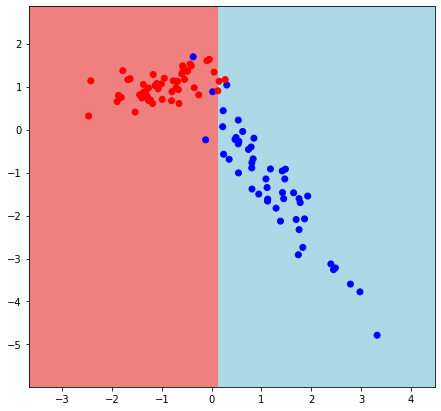

In [14]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) # список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(classification_data)
mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(classification_data[:, 0], classification_data[:, 1], c = classification_labels, cmap = colors)
# plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
# plt.subplot(1,2,2)
# plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
# plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
# plt.title(f'Test accuracy={test_accuracy:.2f}')

In [15]:
n_trees = 3
my_forest_3 = random_forest(classification_data, classification_labels, n_trees)

Точность случайного леса из 3 деревьев на OOB выборке: 91.314


In [16]:
# train_answers = tree_vote(my_forest_3, train_data)
# test_answers = tree_vote(my_forest_3, test_data)
# train_accuracy = accuracy_metric(train_labels, train_answers)
# print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
# # Точность на тестовой выборке
# test_accuracy = accuracy_metric(test_labels, test_answers)
# print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

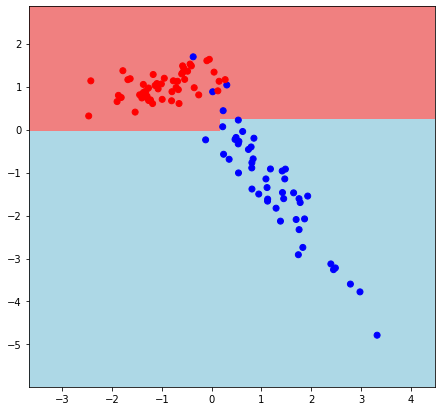

In [17]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) # список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(classification_data)
mesh_predictions = np.array(tree_vote(my_forest_3, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(classification_data[:, 0], classification_data[:, 1], c = classification_labels, cmap = colors)
# plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
# plt.subplot(1,2,2)
# plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
# plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
# plt.title(f'Test accuracy={test_accuracy:.2f}')

In [18]:
n_trees = 10
my_forest_10 = random_forest(classification_data, classification_labels, n_trees)

Точность случайного леса из 10 деревьев на OOB выборке: 91.692


In [19]:
# train_answers = tree_vote(my_forest_10, train_data)
# test_answers = tree_vote(my_forest_10, test_data)
# train_accuracy = accuracy_metric(train_labels, train_answers)
# print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
# test_accuracy = accuracy_metric(test_labels, test_answers)
# print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

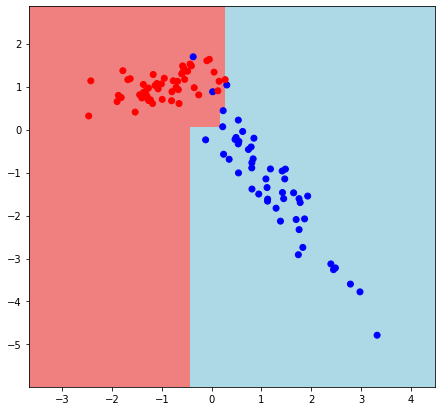

In [20]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) # список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(classification_data)
mesh_predictions = np.array(tree_vote(my_forest_10, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(classification_data[:, 0], classification_data[:, 1], c = classification_labels, cmap = colors)
# plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
# plt.subplot(1,2,2)
# plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
# plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
# plt.title(f'Test accuracy={test_accuracy:.2f}')

In [21]:
n_trees = 50
my_forest_50 = random_forest(classification_data, classification_labels, n_trees)

Точность случайного леса из 50 деревьев на OOB выборке: 92.394


In [22]:
# train_answers = tree_vote(my_forest_50, train_data)
# test_answers = tree_vote(my_forest_50, test_data)
# train_accuracy = accuracy_metric(train_labels, train_answers)
# print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
# test_accuracy = accuracy_metric(test_labels, test_answers)
# print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

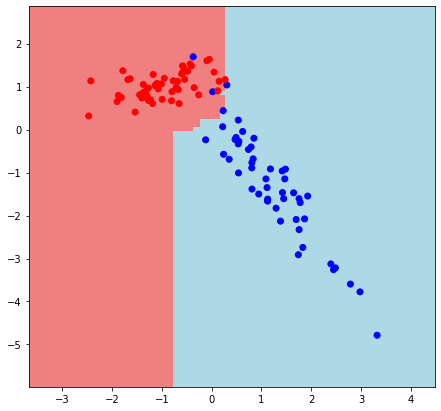

In [23]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) # список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(classification_data)
mesh_predictions = np.array(tree_vote(my_forest_50, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(classification_data[:, 0], classification_data[:, 1], c = classification_labels, cmap = colors)
# plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
# plt.subplot(1,2,2)
# plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
# plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
# plt.title(f'Test accuracy={test_accuracy:.2f}')

#### 2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

С увеличением деревьев в ансамбле мы получаем усложнение гиперплоскости, при этом переобучение отсутствует. Таким образом, точность модели с увеличением деревьев только возрастает.